calculate Error function

function err = calcErr(T, Y)

    vT = (T >= 0);
    
    vY = (Y >= 0);
    
    err = sum(vT ~= vY)/numel(Y);
    
end


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import *
from numpy import *
# for finding k eigen values
import scipy.sparse.linalg

In [2]:
def calculateErr(T, Y):
    vT = (T >= 0);
    vY = (Y >= 0);
    err = sum(vT != vY)/size(Y);
    return err


In [3]:
# function [X, Y] = MixGauss(means, sigmas, n)
# %
# % function [X, Y] = MixGauss(means, sigmas, n)
# %
# % means: (size dxp) and should be of the form [m1, ... ,mp] (each mi is
# % d-dimensional)
# %
# % sigmas: (size px1) should be in the form [sigma_1;...; sigma_p]
# %
# % n: number of points per class
# %
# % X: obtained input data matrix (size 2n x d)
# % Y: obtained output data vector (size 2n)
# %
# % EXAMPLE: [X, Y] = MixGauss([[0;0],[1;1]],[0.5,0.25],1000);
# % generates a 2D dataset with two classes, the first one centered on (0,0)
# % with standard deviation 0.5, the second one centered on (1,1)
# % with standard deviation 0.25.
# % Each class will contain 1000 points.
# %
# % to visualize: scatter(X(:,1),X(:,2),25,Y)

# d = size(means,1);
# p = size(means,2);

# X = [];
# Y = [];
# for i = 1:p
#     m = means(:,i);
#     S = sigmas(i);
#     Xi = zeros(n,d);
#     Yi = zeros(n,1);
#     for j = 1:n
#         x = S*randn(d,1) + m;
#         Xi(j,:) = x;
#         Yi(j) = i;
#     end
#     X = [X; Xi];
#     Y = [Y; Yi];
# end


In [4]:
def MixGauss(means, sigmas, n):
    numRowsOfMeans = means.shape[0];
    numColsOfMeans = means.shape[1];
    
#     X = zeros((200,2))
#     Y = zeros((200,1))
    
#     X = zeros((200,2))
#     Y = zeros((200,1))
    X = []
    Y = []
    for i in range(numColsOfMeans):
        meansOfColumnI = means[:, i]
        sigmaOfI = sigmas[i]
        Xi = zeros((n, numRowsOfMeans))
        Yi = zeros((n, 1))
        
        for j in range(n):
            x = sigmaOfI * random.randn(numRowsOfMeans, 1) + meansOfColumnI
            Xi[j, :] = squeeze(asarray(x))
            Yi[j] = i+1
            
#         tempXi = Xi
#         tempYi = Yi
            
        X.append(Xi)
        Y.append(Yi)
#         X = column_stack(Xi)
#         X = concatenate((Xi, Xi), axis=0)
#         Y = concatenate((Yi, Yi), axis=0)
#         X[0:100,:] = tempXi
#         X[100:200,:] = Xi
#         Y[0:100,:] = tempYi
#         Y[100:200,:] = Yi
    return X, Y
            

In [5]:
# def mixGauss(means=None, sigmas=None, n=None):
#     #
#     # function [X, Y] = MixGauss(means, sigmas, n)
#     #
#     # means: (size dxp) and should be of the form [m1, ... ,mp] (each mi is
#     # d-dimensional)
#     #
#     # sigmas: (size px1) should be in the form [sigma_1;...; sigma_p]
#     #
#     # n: number of points per class
#     #
#     # X: obtained input data matrix (size 2n x d)
#     # Y: obtained output data vector (size 2n)
#     #
#     # EXAMPLE: [X, Y] = MixGauss([[0;0],[1;1]],[0.5,0.25],1000);
#     # generates a 2D dataset with two classes, the first one centered on (0,0)
#     # with standard deviation 0.5, the second one centered on (1,1)
#     # with standard deviation 0.25.
#     # Each class will contain 1000 points.
#     #
#     # to visualize: scatter(X(:,1),X(:,2),25,Y)

#     d = size(means, 1)
#     p = size(means, 2)

#     X = mcat([])
#     Y = mcat([])
#     for i in mslice[1:p]:
#         m = means(mslice[:], i)
#         S = sigmas(i)
#         Xi = zeros(n, d)
#         Yi = zeros(n, 1)
#         for j in mslice[1:n]:
#             x = S * randn(d, 1) + m
#             Xi(j, mslice[:]).lvalue = x
#             Yi(j).lvalue = i
# #         end
#         X = mcat([X, OMPCSEMI, Xi])
#         Y = mcat([Y, OMPCSEMI, Yi])
# #     end

In [6]:
# mixGauss(mcat([mcat([0, OMPCSEMI, 0]), mcat([1, OMPCSEMI, 1])]), mcat([0.5, 0.3]), 100);

In [7]:
# [Xtr, Ytr] = MixGauss([[0;0],[1;1]],[0.5,0.3],100);
# array([[1.,2.,3.], [4.,5.,6.]])

In [6]:
Xtr, Ytr = MixGauss(matrix([[1,1],[-1,-1]]), array([[0.7], [0.7]]), 100)

In [7]:
Xtr = concatenate(Xtr, axis=0)
Ytr = concatenate(Ytr, axis=0)
shape(Xtr)

(200, 2)

In [8]:
Ytr[Ytr==2] = -1

In [41]:
Ytr

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
      

In [9]:
Xts, Yts = MixGauss(matrix([[1,1],[-1,-1]]), array([[0.7], [0.7]]), 100)
Xts = concatenate(Xts, axis=0)
Yts = concatenate(Yts, axis=0)
shape(Xts)

(200, 2)

In [10]:
Yts[Yts==2] = -1;

In [44]:
Yts

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
      

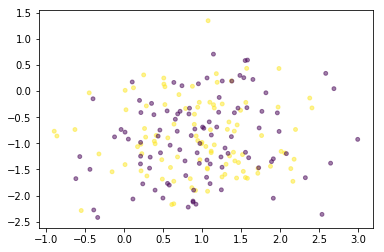

In [11]:
plt.scatter(Xtr[:,0], Xtr[:,1], s=15, c=Ytr, alpha=0.5)
plt.show()

1.C The remaining variables will be generated as gaussian noise

In [12]:
sigma_noise = 0.01;
N = 100
D = 30
Xtr_noise = random.randn(2*N, D-2);
Xts_noise = sigma_noise*random.randn(2*N,D-2);

In [13]:
# Xtr = concatenate(Xtr, Xtr_noise, axis = 1)
shape(Xtr_noise)

(200, 28)

In [14]:
Xtr = concatenate((Xtr, Xtr_noise), axis=1)
Xts = concatenate((Xts, Xts_noise), axis=1)

In [15]:
Xtr.shape

(200, 30)

In [9]:
# function [V, d, X_proj] = PCA(X, k)
# % [V, d, X_proj] = PCA(X, k)
# % computes the first k eigenvectors, eigenvalues and projections of the 
# % matrix X'*X/n where n is the number of rows in X.
# %
# % X is the dataset
# % k is the number of components
# %
# % V is a matrix of the form [v_1, ..., v_k] where v_i is the i-th
# % eigenvector
# % d is the list of the first k eigenvalues
# % X_proj is the projection of X on the linear space spanned by the
# % eigenvectors in V
#     n = size(X,1);
#     [V, D] = eigs(X' * X/n, k);
#     scipy.sparse.linalg.eigs
#     d = diag(D);
#     d = d.*(d>0);
#     [d,I] = sort(d , 'descend');
#     V = V(:,I);
#     X_proj = X*V;
# end

In [16]:
def PCA(X, k):
# [V, d, X_proj] = PCA(X, k)
# computes the first k eigenvectors, eigenvalues and projections of the 
# matrix X'*X/n where n is the number of rows in X.
# 
# X is the dataset
# k is the number of components
# 
# V is a matrix of the form [v_1, ..., v_k] where v_i is the i-th
# eigenvector
# d is the list of the first k eigenvalues
# X_proj is the projection of X on the linear space spanned by the
# eigenvectors in V
    
    numRowsOfX = X.shape[0]
    D, V = scipy.sparse.linalg.eigs((X.conj().transpose().dot(X))/numRowsOfX, k)
#     diagonal = diag(D)
    D = D * (D > 0)
    D, I = sorted(D, reverse = True)
    V = V[:, I]
    X_proj = X.dot(V)
    
    return V, D, X_proj

In [25]:
V, D, X_proj = PCA(Xtr, 2)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# function [ w, r, I ] = OMatchingPursuit( X, Y, T)
# % function [ w, r, I ] = OMatchingPursuit( X, Y, T)
# % Orthogonal Maching Pursuit
# %
# % X input data
# % Y output labels
# % T number of iterations
# %
# % w estimated coefficients
# % r residuals
# % I indices
    
#     [N, D] = size(X);

#     %%% Initialization of residual, coefficient vector and index set I
#     r = Y;
#     w = zeros(D, 1);
#     I = [];
    
#     for i = 1:T-1
        
#         I_tmp = 1:D;
        
# 		%%% Select the column of X which most "explains" the residual
#         a_max = -1;
#         for j = I_tmp
#             a_tmp = ((r' * X(:,j))^2)/(X(:,j)' * X(:,j));
#             if a_tmp > a_max
#                 a_max = a_tmp;
#                 j_max = j;
#             end
#         end
        
# 		%%% Add the index to the set of indexes
#         if sum(I == j_max) == 0
#             I = [I j_max];
#         end
        
        
# 		%%% Compute the M matrix
#         M_I = zeros(D,D);
#         for j = I
#             M_I(j,j) = 1;
#         end
        
#         A = M_I * X' * X * M_I;
#         B = M_I * X' * Y;
        
# 		%%% Update w
#         w = pinv(A) * B;
        
# 		%%% Update the residual
#         r = Y - X*w;
        
#     end
    


# end

In [17]:
def OMatchingPursuit(inputData, outputLabel, numOfIter):
# X = array([[1.,2.,3.], [4.,5.,6.]])
# row, col = shape(X)
    numOfRow, numOfCol = shape(inputData)
    residual = outputLabel
    estimatedCoeff = zeros((numOfCol, 1))
    indices = []
    
    for i in range(1, numOfIter - 1):
        indices_tmp = list(range(1, numOfRow))
        
        a_max = 

In [21]:
A = range(1, 8)
print(A)

range(1, 8)


In [19]:
col

3